In [1]:
import os
import sys
import math
import cv2
import numpy as np
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt

import albumentations as A
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

In [2]:
# Print the versions
print("Python version:", sys.version)
print("Albumentations version:", A.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

Python version: 3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)]
Albumentations version: 1.3.1
TensorFlow version: 2.6.0
Keras version: 2.6.0


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def load_data(path):

    x = []
    y = []

    images = os.listdir(os.path.join(path, 'images'))
    masks = os.listdir(os.path.join(path, 'masks'))
    
    for image, mask in zip(images, masks):
        image_path = os.path.join(path, 'images', image)
        mask_path = os.path.join(path, 'masks', mask)
    
        x.append(image_path)
        y.append(mask_path)

    return x, y

In [5]:
train_path = os.path.abspath('../../datasets/NFBS/preprocessed/train')
val_path = os.path.abspath('../../datasets/NFBS/preprocessed/test')

train_x, train_y = load_data(train_path)
val_x, val_y = load_data(val_path)

print("Train:", len(train_x))
print("Val:", len(val_x))

Train: 5900
Val: 350


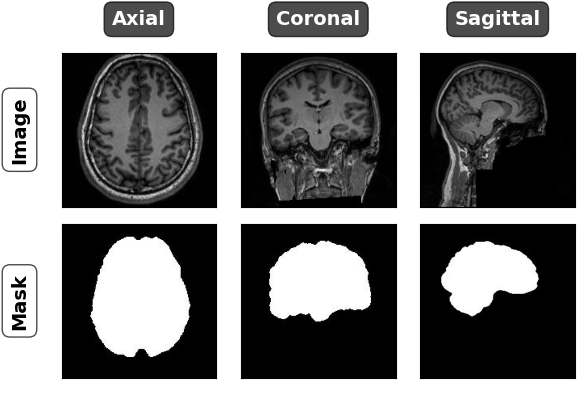

In [6]:
# Paths to the images and masks for sagittalaxial, coronal, and 
image_paths = [train_x[1590], train_x[2456], train_x[5505]]
mask_paths = [train_y[1590], train_y[2456], train_y[5505]]

# Set up the figure with 2 rows and 3 columns (1 row for images and 1 row for masks)
fig, axes = plt.subplots(2, 3, figsize=(6, 4))  # Adjusted the figure size for better visibility

# Loop through and load each image and mask pair
for i in range(3):
    # Read the image using OpenCV
    img = cv2.imread(image_paths[i])
    mask = cv2.imread(mask_paths[i])  

    # Get the dimensions of the image
    h, w = img.shape[:2]
    min_side = min(h, w)  # Get the minimum side length

    # Crop the image and mask according to the type
    if i == 0:  # Axial
        start_x = (w - min_side) // 2
        start_y = 50
    elif i == 1:  # Coronal
        start_x = (w - min_side) // 2 
        start_y = 10 
    elif i == 2:  # Sagittal
        start_x = (w - min_side) // 2
        start_y = h - min_side 

    # Crop the image and the mask
    cropped_img = img[start_y:start_y + min_side, start_x:start_x + min_side]
    cropped_mask = mask[start_y:start_y + min_side, start_x:start_x + min_side]

    # Convert the image from BGR (OpenCV default) to RGB
    img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

    # First row: Display the cropped image
    axes[0, i].imshow(img_rgb)
    axes[0, i].set_xticks([])  # Turn off x-ticks
    axes[0, i].set_yticks([])  # Turn off y-ticks

    # Second row: Display the cropped mask (assuming it's grayscale)
    axes[1, i].imshow(cropped_mask, cmap='gray')
    axes[1, i].set_xticks([])  # Turn off x-ticks
    axes[1, i].set_yticks([])  # Turn off y-ticks

    # Add titles and labels with borders (background boxes)
    title_params = {
        'fontsize': 14, 
        'fontweight': 'bold', 
        'color': 'white', 
        'bbox': dict(facecolor='black', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.4')  # Increased padding here
    }
    label_params = {
        'fontsize': 14, 
        'fontweight': 'bold', 
        'color': 'black', 
        'bbox': dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round, pad=0.4')  # Increased padding here
    }

    if i == 0:
        axes[0, i].set_title("Axial", **title_params, pad=20)  
        axes[0, i].set_ylabel("Image", **label_params, labelpad=20) 
        axes[1, i].set_ylabel("Mask", **label_params, labelpad=20)  
    elif i == 1:
        axes[0, i].set_title("Coronal", **title_params, pad=20)
    elif i == 2:
        axes[0, i].set_title("Sagittal", **title_params, pad=20)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(f'../../plots/outputs/nfbs-mri.pdf', bbox_inches='tight')
plt.show()

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set=None,
                 batch_size=32,
                 img_size=(128, 128),
                 shuffle=True,
                 transform = None):
        
        self.img_paths, self.mask_paths = np.array(x_set), np.array(y_set)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size        
        self.transform = transform
        self.on_epoch_end()

    
    def __getitem__(self, idx):
        batch_img = self.img_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_mask = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        x = np.array([cv2.resize(cv2.imread(p, cv2.IMREAD_GRAYSCALE), self.img_size) for p in batch_img])
        y = np.array([cv2.resize(cv2.imread(p, cv2.IMREAD_GRAYSCALE), self.img_size) for p in batch_mask])

        if self.transform is not None:
            augmented = self.transform(image= x, mask= y)
            image = augmented ['image']
            mask = augmented ['mask']
        
        return image.astype(np.float32)/255., mask.astype(np.float32)/255.

    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.random.permutation(len(self.img_paths)).astype(int)
            self.img_paths, self.mask_paths = self.img_paths[indices], self.mask_paths[indices]

    
    def __len__(self):
        return math.ceil(len(self.img_paths) / self.batch_size)

In [8]:
train_transform = A.Compose([A.Resize (height = 128, width = 128)], p=0.0)
val_transform = A.Compose([A.Resize (height = 128, width = 128)], p=0.0)

In [9]:
batch_size=8

train_gen = DataGenerator(x_set=train_x , y_set=train_y , transform=val_transform, batch_size=batch_size)
val_gen = DataGenerator(x_set=val_x , y_set=val_y , transform=train_transform, batch_size=batch_size)

In [10]:
image, mask = train_gen.__getitem__(0)
image.shape, mask.shape, type(mask), type(mask[0][0][0]), type(image), type(image[0][0][0])

((8, 128, 128),
 (8, 128, 128),
 numpy.ndarray,
 numpy.float32,
 numpy.ndarray,
 numpy.float32)

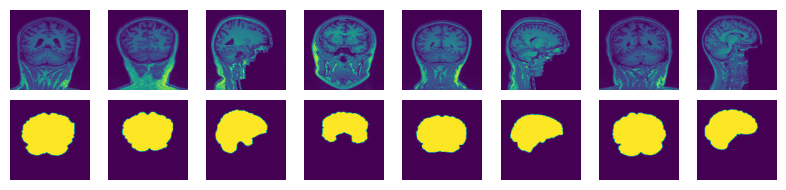

In [11]:
fig, axes = plt.subplots(2, 8, figsize=(8, 2)) 

for i in range(8):
    # Row 1: show the image
    axes[0, i].imshow(image[i])
    axes[0, i].axis('off') 

    # Row 2: show the corresponding mask
    axes[1, i].imshow(mask[i])
    axes[1, i].axis('off') 

# Adjust the layout for better visual clarity
plt.tight_layout()
plt.show()

In [12]:
def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f))
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth))
    return iou

def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f + y_pred_f)
    score = (2. * intersection + smooth) / (union + smooth)
    return score

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
    return loss

In [13]:
def get_unet(input_shape=(None, None,1), num_classes=1):
    
    inputs = Input(shape=input_shape)

    # 128
    down0 = Conv2D(32, (3, 3), padding='same')(inputs)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
    # 64

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 32

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 16

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 8

    center = Conv2D(512, (3, 3), padding='same')(down3_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(512, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up3 = UpSampling2D((2, 2))(center)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 16

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 32

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 64

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    # 128
    
    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0)
    model = Model(inputs=inputs, outputs=classify)

    return model

In [14]:
callbacks = [
    ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.7,  
        patience = 3,  
        min_lr = 1e-6,  
        mode = 'min',
        verbose = 1
    ),
    ModelCheckpoint(
        filepath = os.path.abspath('../../models/segmentation/skullnet.h5'),
        monitor = 'val_loss',
        save_best_only = True,
        mode = 'min'
    ),
    CSVLogger(
        os.path.abspath('../../models/segmentation/skullnet_train.csv'), 
        separator=',', 
        append=False
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=7, 
        restore_best_weights=True,
        mode='min',
        verbose=1  
    )
]

In [15]:
epochs = 150
learning_rate = 0.005
loss = bce_dice_loss
opt = Adam(learning_rate=learning_rate)

In [16]:
model=get_unet()
model.compile(optimizer=opt, loss=loss, metrics=['acc', dice_coef, iou_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
history = model.fit(
    train_gen, 
    batch_size=batch_size, 
    epochs=epochs, 
    steps_per_epoch=len(train_gen),          
    validation_data=val_gen,
    validation_batch_size=batch_size, 
    validation_steps=len(val_gen),
    callbacks=callbacks
)

Epoch 1/150
738/738 [==============================] - 71s 85ms/step - loss: 0.0919 - acc: 0.9235 - dice_coef: 0.9523 - iou_coef: 0.9126 - val_loss: 0.0622 - val_acc: 0.9276 - val_dice_coef: 0.9680 - val_iou_coef: 0.9381
Epoch 2/150
738/738 [==============================] - 38s 51ms/step - loss: 0.0504 - acc: 0.9277 - dice_coef: 0.9746 - iou_coef: 0.9505 - val_loss: 0.0462 - val_acc: 0.9283 - val_dice_coef: 0.9763 - val_iou_coef: 0.9538
Epoch 3/150
738/738 [==============================] - 40s 54ms/step - loss: 0.0448 - acc: 0.9280 - dice_coef: 0.9776 - iou_coef: 0.9562 - val_loss: 0.8233 - val_acc: 0.8412 - val_dice_coef: 0.6440 - val_iou_coef: 0.4814
Epoch 4/150
738/738 [==============================] - 43s 59ms/step - loss: 0.0457 - acc: 0.9279 - dice_coef: 0.9772 - iou_coef: 0.9554 - val_loss: 0.0417 - val_acc: 0.9284 - val_dice_coef: 0.9788 - val_iou_coef: 0.9584
Epoch 5/150
738/738 [==============================] - 45s 61ms/step - loss: 0.0408 - acc: 0.9282 - dice_coef: 0.979

In [18]:
# Loading the model
model = load_model(
    filepath=os.path.abspath('../../models/segmentation/skullnet.h5'), 
    custom_objects={
        'dice_coef': dice_coef, 
        'iou_coef': iou_coef, 
        'bce_dice_loss': bce_dice_loss
    }
)

In [19]:
def skull_stripping(test_image):
    def preprocess_image(image_path, target_size=(128, 128)):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, target_size)  
        image = np.expand_dims(image, axis=-1)  # Add channel dimension (H, W, 1)
        image = np.expand_dims(image, axis=0)  # Add batch dimension (1, H, W, 1)
        image = image.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
        return image
    
    # Load and preprocess the image
    image = preprocess_image(test_image)
    
    # Predict the mask using the trained model
    predicted_mask = model.predict(image)
    
    # Squeeze the predicted mask to remove extra dimensions
    predicted_mask = np.squeeze(predicted_mask)
    
    # Step 1: Threshold the predicted mask (to create a binary mask)
    threshold_value = 0.5
    binary_mask = (predicted_mask > threshold_value).astype(np.float32)
    
    # Step 2: Load the original image (grayscale)
    original_image = cv2.imread(test_image, cv2.IMREAD_GRAYSCALE)
    
    # Resize the original image to the same size as the predicted mask
    if original_image.shape != binary_mask.shape:
        original_image = cv2.resize(original_image, (binary_mask.shape[1], binary_mask.shape[0]))
    
    # Step 3: Apply the mask (black out the background, keep the masked region)
    masked_image = original_image * binary_mask
    
    # Step 5: Display the results
    plt.figure(figsize=(6, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(masked_image, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

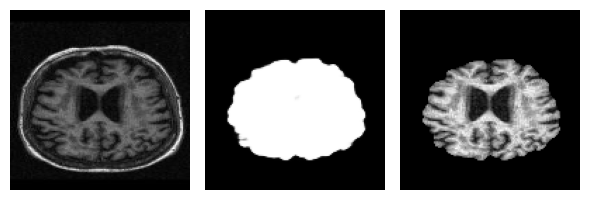

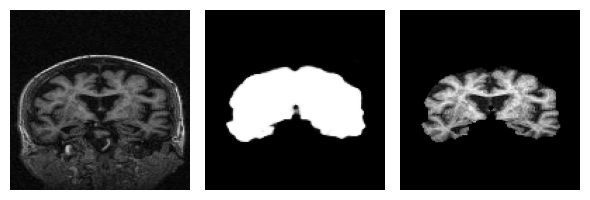

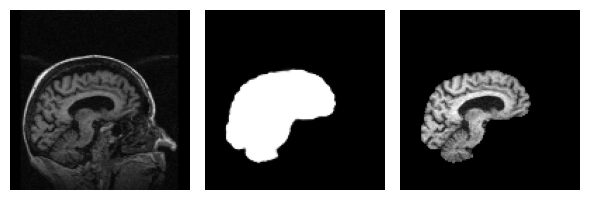

In [20]:
skull_stripping(os.path.abspath('../../datasets/OASIS-2/preprocessed_balanced/train/axial/moderate_dementia/OAS2_0087_MR2_mpr-1_axial_slice_30.jpg'))
skull_stripping(os.path.abspath('../../datasets/OASIS-2/preprocessed_balanced/train/coronal/moderate_dementia/OAS2_0087_MR2_mpr-1_coronal_slice_30.jpg'))
skull_stripping(os.path.abspath('../../datasets/OASIS-2/preprocessed_balanced/train/sagittal/moderate_dementia/OAS2_0087_MR2_mpr-1_sagittal_slice_30.jpg'))